# Param VaR

Variance-covariance method.

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [39]:
import datetime
import requests
import yfinance as yf
from io import StringIO


tickers = ['IBM', 'MSFT', 'INTC']
start_day = datetime.datetime(2020, 1, 1)
end_day = datetime.datetime(2020, 12, 31)
data = yf.download(tickers, start=start_day, end=end_day, interval='1d')['Close']

data.head()

[*********************100%%**********************]  3 of 3 completed


,IBM,INTC,MSFT
Date,,,
2020-01-02,129.464630,60.840000,160.619995
2020-01-03,128.432129,60.099998,158.619995
2020-01-06,128.202682,59.930000,159.029999
2020-01-07,128.288712,58.930000,157.580002
2020-01-08,129.359467,58.970001,160.089996


In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2020-01-02 to 2020-12-30
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IBM     252 non-null    float64
 1   INTC    252 non-null    float64
 2   MSFT    252 non-null    float64
dtypes: float64(3)
memory usage: 7.9 KB


In [41]:
data.columns

Index(['IBM', 'INTC', 'MSFT'], dtype='object')

## Bước 1: Tính lợi nhuận hàng ngày của từng cổ phiếu

In [42]:
rets = data.pct_change()    # calculate logarithmic return
rets.head()

,IBM,INTC,MSFT
Date,,,
2020-01-02,NaN,NaN,NaN
2020-01-03,-0.007975,-0.012163,-0.012452
2020-01-06,-0.001787,-0.002829,0.002585
2020-01-07,0.000671,-0.016686,-0.009118
2020-01-08,0.008346,0.000679,0.015928


In [43]:
rets.dropna(inplace=True)
rets.head()

,IBM,INTC,MSFT
Date,,,
2020-01-03,-0.007975,-0.012163,-0.012452
2020-01-06,-0.001787,-0.002829,0.002585
2020-01-07,0.000671,-0.016686,-0.009118
2020-01-08,0.008346,0.000679,0.015928
2020-01-09,0.010568,0.005596,0.012493


## Bước 2: Tính ma trận hiệp phương sai dựa vào lợi nhuận hàng ngày

In [44]:
mean_rets = rets.mean()   # calculate average return for each stock
print(mean_rets)

# Generate random weights
weights = np.array([2., 1., 3.])
weights /= np.sum(weights)
print(weights)

# Calculate portfolio's std
cov_mat = rets.cov()
ptf_std = np.sqrt(weights.T.dot(cov_mat).dot(weights))

# Calculate portfolio's mean
ptf_mean = mean_rets.dot(weights)

ptf_mean, ptf_std

IBM    -0.000006
INTC   -0.000309
MSFT    0.001669
dtype: float64
[0.33333333 0.16666667 0.5       ]


(0.0007809734980347943, 0.02503022190611625)

In [45]:
cov_mat

,IBM,INTC,MSFT
IBM,0.000667,0.000560,0.000461
INTC,0.000560,0.001136,0.000676
MSFT,0.000461,0.000676,0.000769


## Bươc 3: Tính VaR dựa vào hàm quantile

In [46]:
from scipy.stats import norm     # normal variable


init_investment = 1e6            # ta thường tính VaR dựa theo tỷ lệ của danh mục nên ta thường không sử dụng giá trị này
conf_level = 0.95

def param_VaR(init_investment, conf_level, weights=True):

    ptf_VaR_95 = norm.ppf((1 - conf_level), ptf_mean, ptf_std)

    stock_VaR_95 = {}
    for stock in data.columns:
        stock_VaR_95[stock] = norm.ppf((1 - conf_level), mean_rets[stock], np.sqrt(cov_mat.loc[stock, stock]))   # location of [id_name, col_name]

    return ptf_VaR_95, stock_VaR_95

param_VaR(init_investment, conf_level)

(-0.04039007778764071,
 {'IBM': -0.04249078194492907,
  'INTC': -0.05575003229867209,
  'MSFT': -0.04395785387752194})

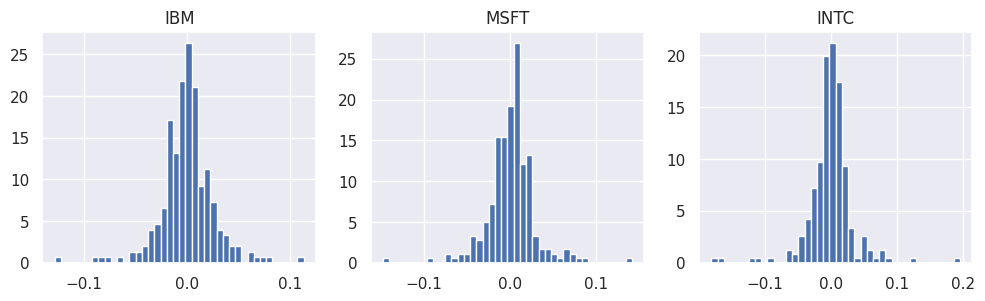

In [47]:
# Kiểm tra giả sử về phân phối chuẩn của các cổ phiếu
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
for i, ticker in enumerate(tickers):
    axes[i].hist(rets[ticker], bins=40, density=True)
    axes[i].set_title(ticker)
plt.show()

Nhận xét: Ta thấy phân phối của MSFT lệch về phía bên phải, đó là lý do vì sao VaR của MSFT lại có giá trị dương.

## n-day VaR

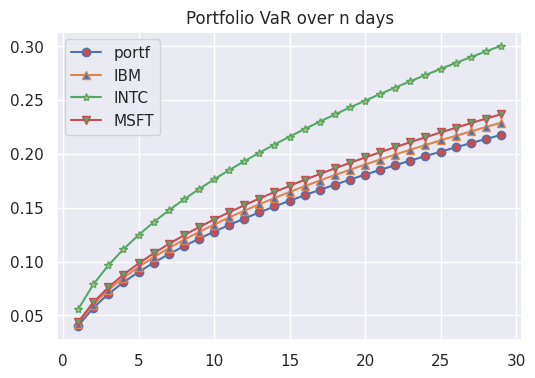

In [48]:
ptf_VaR, stock_VaR = param_VaR(init_investment, conf_level)
n_days_VaR = {}
for i in range(1, 30):
    if i == 1:
        n_days_VaR['portf'] = [-ptf_VaR * np.sqrt(i)]
        for ticker in stock_VaR:
            n_days_VaR[ticker] = [-stock_VaR[ticker] * np.sqrt(i)]
    else:
        n_days_VaR['portf'].append(-ptf_VaR * np.sqrt(i))
        for ticker in stock_VaR:
            n_days_VaR[ticker].append(-stock_VaR[ticker] * np.sqrt(i))

markers = ['o', '^', '*', 'v']
markerfacecolors = ['r', 'b', 'y', 'g']
plt.figure(figsize=(6, 4))
for i, ticker in enumerate(n_days_VaR.keys()):
    plt.plot(range(1, 30), n_days_VaR[ticker],
             marker=markers[i],
             markerfacecolor=markerfacecolors[i],
             label=ticker)
plt.legend()
plt.title('Portfolio VaR over n days')
plt.show()

Nhận xét: Ta có thể thấy VaR của danh mục là thấp nhất, đó là nhờ lợi ích của việc đa dạng hóa cổ phiếu trong danh mục đầu tư.

# Historical (simulation) method

Còn được gọi là nonparametric VaR, vì nó không yêu cầu giả sử về phân phối của lợi nhuận.

Ý tưởng: Đây là phương pháp thực nghiệm, ta sẽ đi tìm percentile - tương đương với bảng Z của phương pháp variance-covariance. Khi đó, ta chỉ cần sắp xếp lợi nhuận theo độ lớn tăng dần rồi tìm giá trị percentile tương ứng.

In [49]:
data.columns

Index(['IBM', 'INTC', 'MSFT'], dtype='object')

In [50]:
def historical_VaR(conf_level):
    ptf_VaR = np.percentile(rets.sum(axis=1), 1 - conf_level)

    stock_VaR = {}
    for stock in data.columns:
        stock_VaR[stock] = np.percentile(rets[stock], 1 - conf_level)

    return ptf_VaR, stock_VaR

historical_VaR(conf_level=0.95)

(-0.401453060276392,
 {'IBM': -0.12385911107391877,
  'INTC': -0.1781654595303123,
  'MSFT': -0.14082131030600292})

Nhận xét: So với phương pháp Gaussian VaR ở trên thì các giá trị VaR ở phương pháp này đều có độ lớn lớn hơn.

Tổng kết: Như vậy, đê tính historical VaR, ta chỉ cần một mảng lợi nhuận của các cổ phiểu trong danh mục, từ đó ta có thể tính được historical VaR cho cả danh mục và cho từng cổ phiểu riêng lẻ.

# Monto Carlo VaR

Ví dụ về MC: Tính số $\pi$

Công thức để xấp xỉ số $\pi$ là:
\begin{align}
\pi = 4 \times \frac{m}{n}
\end{align}
với $m$ và $n$ lần lượt là diện tích của hình vuông có cạnh bằng 1 và hình tròn có bán kính bằng 1.

In [51]:
def calc_pi(x, y):
    n_points_inside_circle = 0
    for x_, y_ in zip(x, y):
        if np.sqrt(x_**2 + y_**2 <= 1):
            n_points_inside_circle += 1

    return 4 * n_points_inside_circle / len(x)     # approximate pi

In [52]:
samples = [100, 1000, 10_000, 100_000, 1_000_000]

for n_sample in samples:
    # Generate n_sample random sample inside the square
    x = np.random.uniform(-1, 1, n_sample)
    y = np.random.uniform(-1, 1, n_sample)

    pi = calc_pi(x, y)
    print(f'n_sample = {n_sample}, pi = {pi:.8f}')

n_sample = 100, pi = 3.12000000
n_sample = 1000, pi = 3.06400000
n_sample = 10000, pi = 3.17320000
n_sample = 100000, pi = 3.14088000
n_sample = 1000000, pi = 3.14276000


Áp dụng MC để tính MC VaR:

Ý tưởng:
- Giả sử về phân phối của lợi nhuận của các cổ phiếu (thường là phân phối chuẩn.
- Từ giả sử về phân phối, cho ra các tham số của phân phối và lấy mẫu ngẫu nhiên.
- Khi đã có dữ liệu mô phỏng, ta tính VaR bằng hàm percentile (lúc này giống hệt với historical VaR).

In [53]:
np.random.rand(3).mean()

0.45226683950267016

In [54]:
np.random.rand(3)

array([0.0168393 , 0.5954766 , 0.09796205])

# Tông kết 3 phương pháp

## Ưu điểm

## Nhược điểm